In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_parquet("../input/amex-parquet/train_data.parquet")

In [3]:
train.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

In [4]:
train.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,5.485466e+06,5.531451e+06,5.531451e+06,5.529435e+06,5.531451e+06,4.510907e+06,5.529435e+06,5.529435e+06,791314.000000,3.873055e+06,...,1.946990e+05,1.946990e+05,5.429903e+06,5.490819e+06,5.429903e+06,944408.000000,5.429903e+06,5.490724e+06,5.429903e+06,5.531451e+06
mean,6.563343e-01,1.531172e-01,1.240101e-01,6.214890e-01,7.880273e-02,2.258454e-01,5.978473e-02,1.325390e-01,0.184974,1.546841e-01,...,1.424409e-02,1.646184e-01,1.789304e-01,2.664348e-02,1.645212e-01,0.390799,1.788023e-01,5.238953e-02,6.233494e-02,2.490972e-01
std,2.446494e-01,2.700709e-01,2.119869e-01,4.014876e-01,2.263971e-01,1.933475e-01,2.025443e-01,2.349929e-01,0.228185,2.133977e-01,...,9.571116e-02,2.670208e-01,3.790614e-01,1.455480e-01,3.482771e-01,0.236182,3.789498e-01,1.825135e-01,1.934937e-01,4.324903e-01
min,-4.589548e-01,5.026190e-09,-7.588799e+00,9.192280e-09,1.534223e-09,-6.271321e-01,5.566545e-10,6.285293e-09,-0.000454,1.154550e-07,...,1.078787e-08,3.307923e-08,3.767347e-10,3.725073e-09,1.650100e-10,-0.014539,5.549692e-09,2.500991e-09,1.226024e-09,0.000000e+00
25%,4.803307e-01,4.528464e-03,8.863645e-03,1.053313e-01,2.895934e-03,1.272588e-01,2.873244e-03,5.227570e-03,0.037516,4.227546e-02,...,2.532470e-03,3.517452e-03,3.027212e-03,2.555848e-03,3.026087e-03,0.199399,3.028116e-03,2.752895e-03,3.028347e-03,0.000000e+00
50%,6.942950e-01,9.056902e-03,3.132968e-02,8.143328e-01,5.782230e-03,1.639082e-01,5.746725e-03,9.777229e-03,0.120519,8.851244e-02,...,5.069830e-03,7.037814e-03,6.053010e-03,5.110523e-03,6.051590e-03,0.382136,6.053151e-03,5.508129e-03,6.053247e-03,0.000000e+00
75%,8.648159e-01,2.366407e-01,1.259019e-01,1.002403e+00,8.660590e-03,2.581017e-01,8.615665e-03,1.550507e-01,0.250869,1.843206e-01,...,7.573434e-03,5.015469e-01,9.080455e-03,7.663697e-03,9.078914e-03,0.559307,9.076287e-03,8.260448e-03,9.080930e-03,0.000000e+00
max,1.010000e+00,5.389619e+00,1.324060e+00,1.010000e+00,3.256284e+00,5.482888e+00,8.988807e+00,1.625262e+00,4.191119,1.011162e+01,...,1.009998e+00,3.005383e+00,1.010000e+00,1.010000e+00,1.339910e+00,2.229368,1.010000e+00,1.343331e+00,4.827630e+00,1.000000e+00


# Missing Column Analysis

In [5]:
missing_df = train.isnull().sum().reset_index()
missing_df = missing_df.rename(columns={"index":"columns",0:"missing_value"})
missing_df = missing_df.query("missing_value>0")

In [6]:
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 2 to 189
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   columns        122 non-null    object
 1   missing_value  122 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


In [7]:
print(missing_df.describe())
print(missing_df.max())
print(missing_df.min())

       missing_value
count   1.220000e+02
mean    1.318516e+06
std     2.059408e+06
min     1.000000e+00
25%     1.971125e+04
50%     1.429595e+05
75%     2.300033e+06
max     5.527586e+06
columns              S_9
missing_value    5527586
dtype: object
columns          B_13
missing_value       1
dtype: object


In [8]:
fig = px.bar(y=missing_df["columns"],x=missing_df["missing_value"])
fig.update_layout(showlegend=False, 
                  title_text="Column Wise Null Value Distribution", 
                  title_x=0.5,
                  xaxis_title="Missing Value Count",
                  yaxis_title="Column Name")
fig.show()


# Observations:

* We have 122 NULL value columns in our train dataset. Almost 63% of columns in our dataset have NULL values.

* Column B_13 has the least number of null values (1 NULL value)

* Column S_9 has the maximum number of null values (5527586)





# Different feature types

Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables

S_* = Spend variables

P_* = Payment variables

B_* = Balance variables

R_* = Risk variables

In [9]:
d_feats = [c for c in train.columns if c.startswith('D_')]
s_feats = [c for c in train.columns if c.startswith('S_')]
p_feats = [c for c in train.columns if c.startswith('P_')]
b_feats = [c for c in train.columns if c.startswith('B_')]
r_feats = [c for c in train.columns if c.startswith('R_')]

In [10]:
dtypes = train.dtypes.reset_index()
dtypes = dtypes.rename(columns={"index":"Column_name",0:"dtype_name"})
dtypes = dtypes.groupby(by=["dtype_name"]).size().reset_index(name="counts")
dtypes

,dtype_name,counts
0,float32,185
1,int64,2
2,object,4


We have 4 object columns, 185 float and 2 integer columns 

# Target Analysis

In [11]:
target_ana = train.groupby(by=["target"]).size().reset_index(name="counts")
fig = px.bar(data_frame=target_ana,x="target",y="counts",color = 'target')
fig.show()

# Observations

Our training dataset has unequal target distribution.

We have lesser number of defaulters than the ones who do not default, which does make sense considering a real world scenario.

Using stratified k fold could be a strategy we employ while training the model.

# Card statements per user

In [12]:
target_cust = train.groupby(by=["customer_ID"]).size().reset_index(name="counts")
target_cust = target_cust.groupby(by=["counts"]).size().reset_index(name="number_per_count")
fig = px.pie(target_cust,names="counts",values="number_per_count",title="NUmber of statements per customer id")
fig.show()

# Observations

Most of the customers almost 84% have 13 card statements (almost over a year)

But for some customers we have statements for only a single month.

In that case we would need to have a strategy that takes this into consideration while modelling.

# Visualising categorical object features

In [13]:
train.select_dtypes(include=['object'])

,customer_ID,S_2,D_63,D_64
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,CR,O
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,CR,O
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,CR,O
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,CR,O
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,CR,O
...,...,...,...,...
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,CL,O
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,CL,O
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,CL,O
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,CL,O


In [14]:
target_by_date = train.groupby(by=["S_2"]).size().reset_index(name="counts")

In [15]:
px.line(target_by_date,x="S_2",y="counts",title="Number of statements generated by date")

# Observations

On analysing the pattern from months March to May 2017, I could see that in a week most statements are generated on a  Saturday and there is a considerable drop in the number of statements generated on Sundays, after which throughout the week the number of statements show an upward trend maxing on Saturday.

In [16]:
target_by_d63 = train.groupby(by=["D_63"]).size().reset_index(name="counts")

In [17]:
target_by_d63

,D_63,counts
0,CL,438390
1,CO,4119621
2,CR,930133
3,XL,6965
4,XM,10556
5,XZ,25786


In [18]:
px.bar(target_by_d63,x="D_63",y="counts",color="D_63",title="Distribution of D_63")

# Observations:

Delinquency means minor crime, these variables seem to be depicting some sort of negligience by the credit card holder.

CO is the category with the most number of counts.

In [19]:
target_by_d64 = train.groupby(by=["D_64"]).size().reset_index(name="counts")

In [20]:
px.bar(target_by_d64,x="D_64",y="counts",color="D_64",title="Distribution of D_64")

# Visualising integer features

In [21]:
train.select_dtypes(include=['int'])

,B_31,target
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
5531446,1,0
5531447,1,0
5531448,1,0
5531449,1,0


In [22]:
target_by_b31 = train.groupby(by=["B_31"]).size().reset_index(name="counts")

In [23]:
px.bar(target_by_b31,x="B_31",y="counts",color="B_31",title="Distribution of B_31")

# Correlation of variables with the target feature

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:>

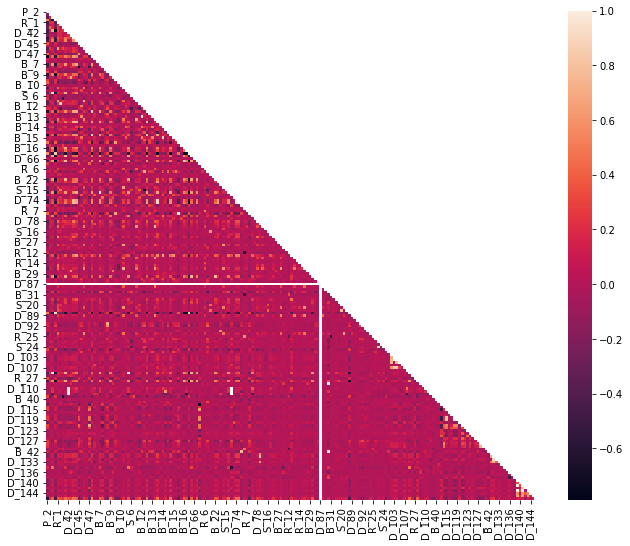

In [24]:
corr = train.sample(frac=0.1, random_state=42).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(11, 9))
sns.heatmap(corr,mask=mask)

**Some features are highly correlated.**

In [25]:
#Code reference: https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

iters = range(len(corr.columns) - 1)
drop_cols = []
threshold = 0.9
print("Highly correlated features with their correlation values")
    # Iterate through the correlation matrix and compare correlations
for i in iters:
        for j in range(i+1):
            item = corr.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])


Highly correlated features with their correlation values
B_11 | B_1 | 1.0
S_7 | S_3 | 0.9
B_13 | B_12 | 0.94
B_15 | B_14 | 0.9
B_23 | B_7 | 1.0
D_74 | D_58 | 0.92
D_75 | D_58 | 0.93
D_75 | D_74 | 0.99
D_77 | D_62 | 1.0
B_33 | B_2 | 0.91
S_24 | S_22 | 0.92
D_104 | D_103 | 1.0
B_37 | B_1 | 0.99
B_37 | B_11 | 0.99
D_110 | D_42 | 1.0
D_111 | D_42 | 1.0
B_39 | D_42 | 1.0
D_119 | D_118 | 0.99
B_42 | D_88 | 1.0
D_141 | D_139 | 1.0
D_143 | D_139 | 1.0
D_143 | D_141 | 1.0


**Let's remove the highly correlated features**

In [26]:
# Drop one of each pair of correlated columns
drops = set(drop_cols)
#train = train.drop(columns=drops)


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 4.1+ GB


# Modelling

**Reference:https://www.kaggle.com/code/munumbutt/simple-lgbm-starter**

In [28]:
%%time
# Keep the last statement month per customer
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327094
train =  (train
            .groupby('customer_ID')
            .tail(1)
            .set_index('customer_ID', drop=True)
            .sort_index()
            .drop(['S_2'], axis='columns'))

CPU times: user 2.52 s, sys: 573 ms, total: 3.1 s
Wall time: 3.1 s


In [29]:
train.shape

(458913, 189)

In [30]:
total_cols = train.columns.to_list()
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

num_cols = [col for col in total_cols if col not in cat_cols + ["target"]]

In [31]:
X = train[cat_cols+num_cols]
y = train["target"]



In [32]:
%%time
enc = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)
X[cat_cols] = enc.fit_transform(X[cat_cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 1.19 s, sys: 709 ms, total: 1.9 s
Wall time: 1.89 s


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [34]:
clf = LGBMClassifier(
    n_estimators=50000,
    random_state=72,
    extra_trees=True
)

In [35]:
%%time
clf.fit(
    X_train, y_train, 
    eval_set=[(X_test,y_test)],
    callbacks=[early_stopping(50), log_evaluation(0)]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.222687
CPU times: user 3min 25s, sys: 901 ms, total: 3min 26s
Wall time: 53.8 s


LGBMClassifier(extra_trees=True, n_estimators=50000, random_state=72)

In [36]:
import gc
del train, X, y, X_test, X_train, y_train, y_test
_ = gc.collect()

In [37]:
#del test

In [38]:
test = pd.read_feather("../input/amexfeather/test_data.ftr")

In [39]:
test =  (
    test
    .groupby('customer_ID')
    .tail(1)
    .set_index('customer_ID', drop=True)
    .sort_index()
    .drop(['S_2'], axis='columns')
)
test[cat_cols] = enc.transform(test[cat_cols])
test["prediction"] = clf.predict_proba(test[cat_cols + num_cols])[:,1]
test.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,prediction
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.568848,0.121399,0.010780,1.009766,0.006924,0.149414,0.000396,0.003576,0.10376,0.007397,...,NaN,NaN,0.005913,0.001250,0.006542,NaN,0.009163,0.003691,0.003220,0.033748
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.841309,0.126465,0.016556,1.008789,0.009712,0.112183,0.006191,0.011383,NaN,NaN,...,NaN,NaN,0.004345,0.000866,0.009117,NaN,0.002197,0.000247,0.007778,0.001791
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.697754,0.002724,0.001485,0.810059,0.002621,0.166138,0.004887,0.015945,NaN,0.105286,...,NaN,NaN,1.000977,0.008896,0.895996,0.150146,1.009766,0.457764,0.092041,0.025191
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.513184,0.324707,0.149536,0.205688,0.002277,0.181152,0.005814,0.498535,NaN,0.211670,...,NaN,NaN,1.007812,0.003754,0.919922,0.255371,1.007812,0.500977,0.182983,0.224603
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.254395,0.768066,0.563477,0.038025,0.502930,0.168335,0.009483,0.831055,NaN,0.071899,...,NaN,NaN,0.006622,0.001140,0.009529,NaN,0.009407,0.001557,0.000525,0.872615


In [40]:
pred = pd.DataFrame()
#pred["customer_ID"] = test["customer_ID"]
pred["prediction"] = test["prediction"]

In [41]:
test["prediction"].to_csv("submission.csv", index=True)

# Work in Progress